In [ ]:
# Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("dataset\Sleep_data__norm_ML2568.csv")
print("Loaded dataset shape:", df.shape)

Loaded dataset shape: (11470, 143)


In [ ]:
# SLOT 2: Cleaning & Preprocessing

target_col = 'f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain_norm:allday'

# # drop col with no norm in its name and print the dropped names
# cols_to_drop = [col for col in df.columns if 'norm' not in col]
# df = df.drop(columns=cols_to_drop)
# print("Dataset shape after dropping non-norm columns:", df.shape)
# print("Dropped columns:", cols_to_drop)

# drop col 0, date_, f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:allday
df = df.drop(df.columns[0], axis=1)
df = df.drop(columns=['date_'], errors='ignore')
df = df.drop(columns=['f_slp:fitbit_sleep_summary_rapids_sumdurationasleepmain:allday'], errors='ignore')

# move date and pid cols for later use
later_use_cols = df[['date', 'pid']].copy()
df = df.drop(columns=['date', 'pid'], errors='ignore')

# convert pid to numeric with one hot encoding
later_use_cols['pid_num'] = later_use_cols['pid'].str.extract('(\d+)').astype(int)
later_use_cols = later_use_cols.drop(columns=['pid'], errors='ignore')

# convert date into separate date columns
later_use_cols['date'] = pd.to_datetime(later_use_cols['date'], errors='coerce')
later_use_cols['day'] = later_use_cols['date'].dt.day
later_use_cols['month'] = later_use_cols['date'].dt.month
later_use_cols['year'] = later_use_cols['date'].dt.year
later_use_cols = later_use_cols.drop(columns=['date'], errors='ignore')
later_use_cols = later_use_cols.drop(columns=['year'], errors='ignore') # year are all the same

# use cyclic encoding for month and day
later_use_cols['day_sin'] = np.sin(2 * np.pi * later_use_cols['day'] / 31)
later_use_cols['day_cos'] = np.cos(2 * np.pi * later_use_cols['day'] / 31)
later_use_cols = later_use_cols.drop(columns=['day'], errors='ignore')

later_use_cols['month_sin'] = np.sin(2 * np.pi * later_use_cols['month'] / 12)
later_use_cols['month_cos'] = np.cos(2 * np.pi * later_use_cols['month'] / 12)
later_use_cols = later_use_cols.drop(columns=['month'], errors='ignore')

print("Later use cols shape:", later_use_cols.shape)
later_use_cols.head()

Later use cols shape: (11470, 5)


,pid_num,day_sin,day_cos,month_sin,month_cos
0,1,0.571268,0.820763,0.866025,-0.5
1,1,0.724793,0.688967,0.866025,-0.5
2,1,0.848644,0.528964,0.866025,-0.5
3,1,0.937752,0.347305,0.866025,-0.5
4,1,0.988468,0.151428,0.866025,-0.5


In [36]:

# df = df.drop(columns=['pid', 'date', 'date_'], errors='ignore')  # drop non-informative columns
# print("After dropping non-informative cols shape:", df.shape)

# add later_use_cols back to df
df = pd.concat([df, later_use_cols], axis=1)
print("After adding later_use_cols shape:", df.shape)

# drop rows with missing col val > 70%
row_missing_ratio = df.isna().mean(axis=1)
df = df.loc[row_missing_ratio <= 0.7]
print("After dropping high-missing rows shape:", df.shape)

# 2.1 ดรอปคอลัมน์ที่ missing > 70%
missing_ratio = df.isnull().sum() / len(df)
df = df.loc[:, missing_ratio <= 0.7]
print("After dropping high-missing cols shape:", df.shape)

# replace missing values with MI (Mutual Information)
from sklearn.feature_selection import mutual_info_regression

df_with_target = df.dropna(subset=[target_col]).copy()
df_without_target = df[df[target_col].isna()].copy()
print(f"Dataset shape: {df.shape}")
print(f"Rows with target: {len(df_with_target)} size: {df_with_target.shape}")
print(f"Rows without target: {len(df_without_target)} size: {df_without_target.shape}")

# Count rows that have at least 70% non-missing values
rows_with_enough_data = df_with_target[df_with_target.notna().mean(axis=1) >= 0.7]
print("Rows with at least 70% non-missing values:", rows_with_enough_data.shape[0])
# Use rows_with_enough_data to compute fill values. median because it's robust to outliers
fill_values = rows_with_enough_data.median(numeric_only=True)
# Fill missing values in df_with_target using those values
df_with_target = df_with_target.fillna(fill_values)

print("After filling missing values shape:", df_with_target.shape)

# Calculate Mutual Information scores
mi_scores = mutual_info_regression(
    df_with_target.drop(columns=[target_col]),
    df_with_target[target_col],
    discrete_features='auto',
    random_state=42
)
mi_series = pd.Series(mi_scores, index=df_with_target.drop(columns=[target_col]).columns)
mi_series = mi_series.sort_values(ascending=False)
print("Mutual Information scores:\n", mi_series)

# drop features with MI score of 0 except month_sin, month_cos, day_sin, day_cos, pid_num
zero_mi_cols = mi_series[mi_series == 0].index.tolist()
keep_cols = ["month_sin", "month_cos", "day_sin", "day_cos", "pid_num"]
zero_mi_cols = [col for col in zero_mi_cols if col not in keep_cols]
df_with_target = df_with_target.drop(columns=zero_mi_cols)
print("After dropping zero-MI cols shape:", df_with_target.shape)

After adding later_use_cols shape: (11470, 143)
After dropping high-missing rows shape: (9929, 143)
After dropping high-missing cols shape: (9929, 93)
Dataset shape: (9929, 93)
Rows with target: 6460 size: (6460, 93)
Rows without target: 3469 size: (3469, 93)
Rows with at least 70% non-missing values: 6010
After filling missing values shape: (6460, 93)
Mutual Information scores:
 f_screen:phone_screen_rapids_sumdurationunlock_locmap_living_norm:evening    0.036494
f_slp:fitbit_sleep_summary_rapids_avgefficiencymain_norm:allday              0.027627
f_loc:phone_locations_doryab_timeathome_norm:night                           0.024964
f_loc:phone_locations_doryab_totaldistance_norm:night                        0.021588
f_steps:fitbit_steps_intraday_rapids_countepisodeactivebout_norm:evening     0.016720
                                                                               ...   
f_steps:fitbit_steps_intraday_rapids_sumsteps_norm:evening                   0.000000
f_steps:fitbit_

In [37]:
# drop target col from features

X = df_with_target.drop(columns=[target_col], errors='ignore')
y = df_with_target[target_col]

print("X shape:", X.shape)
print("y shape:", y.shape)

# print col name in x
print("Example feature columns:", X.columns)


X shape: (6460, 63)
y shape: (6460,)
Example feature columns: Index(['f_slp:fitbit_sleep_summary_rapids_avgefficiencymain:allday',
       'f_slp:fitbit_sleep_summary_rapids_avgefficiencymain_norm:allday',
       'f_blue:phone_bluetooth_doryab_uniquedevicesall_norm:night',
       'f_call:phone_calls_rapids_missed_count_norm:allday',
       'f_call:phone_calls_rapids_incoming_count_norm:allday',
       'f_call:phone_calls_rapids_outgoing_count_norm:allday',
       'f_call:phone_calls_rapids_outgoing_sumduration_norm:allday',
       'f_loc:phone_locations_doryab_movingtostaticratio_norm:afternoon',
       'f_loc:phone_locations_locmap_duration_in_locmap_study_norm:afternoon',
       'f_loc:phone_locations_locmap_duration_in_locmap_greens_norm:afternoon',
       'f_loc:phone_locations_barnett_rog_norm:allday',
       'f_loc:phone_locations_barnett_siglocsvisited_norm:allday',
       'f_loc:phone_locations_barnett_wkenddayrtn_norm:allday',
       'f_loc:phone_locations_doryab_movingtostatic

In [38]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


In [39]:
def train_evaluate_model(model, X, y, model_name="Model", n_splits=5, scale=False, plot_last_fold=True):
    """
    Train and evaluate a regression model using K-Fold CV.

    Parameters:
        model: sklearn-like or XGBoost model with .fit() and .predict()
        X: pandas DataFrame or numpy array of features
        y: pandas Series or numpy array of target
        model_name: string, name of the model for display
        n_splits: int, number of K-Folds
        scale: bool, whether to standardize features (recommended for MLP/Linear models)
        plot_last_fold: bool, whether to plot predictions of the last fold
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    mae_list, rmse_list, r2_list = [], [], []

    # Print model's input size
    if hasattr(X, "shape"):
        print(f"{model_name} input feature size: {X.shape}")
    else:
        print(f"{model_name} input feature size: {X.shape}")  # for numpy arrays

    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        # Properly select rows for pandas or numpy
        if hasattr(X, "iloc"):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        else:
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
    
        # Optionally scale
        if scale:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled  = scaler.transform(X_test)
        else:
            X_train_scaled = X_train.values if hasattr(X_train, "values") else X_train
            X_test_scaled  = X_test.values if hasattr(X_test, "values") else X_test
    
        # Train model
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        # Evaluate
        mae  = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2   = r2_score(y_test, y_pred)

        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)

        print(f"{model_name} — Fold {fold} | MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

    # Print average metrics
    print(f"\n{model_name} — Average across {n_splits} folds:")
    print(f"MAE  : {np.mean(mae_list):.4f}")
    print(f"RMSE : {np.mean(rmse_list):.4f}")
    print(f"R²   : {np.mean(r2_list):.4f}")

    # Plot last fold
    if plot_last_fold:
        plt.figure(figsize=(6,6))
        plt.scatter(y_test, y_pred, alpha=0.5, color='darkorange')
        plt.xlabel("Actual Sleep Duration (normalized)")
        plt.ylabel("Predicted Sleep Duration (normalized)")
        plt.title(f"{model_name} — Predicted vs Actual (Last Fold)")

        low, high = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
        plt.plot([low, high], [low, high], 'r--')
        plt.show()
    
    return np.mean(mae_list), np.mean(rmse_list), np.mean(r2_list)

MLP Regressor input feature size: (6460, 63)
MLP Regressor — Fold 1 | MAE: 0.3156, RMSE: 0.4179, R²: -0.5121
MLP Regressor — Fold 2 | MAE: 0.3053, RMSE: 0.4076, R²: -0.4157
MLP Regressor — Fold 3 | MAE: 0.3109, RMSE: 0.4167, R²: -0.5523
MLP Regressor — Fold 4 | MAE: 0.3039, RMSE: 0.4109, R²: -0.5242
MLP Regressor — Fold 5 | MAE: 0.3119, RMSE: 0.4105, R²: -0.4528

MLP Regressor — Average across 5 folds:
MAE  : 0.3095
RMSE : 0.4127
R²   : -0.4914


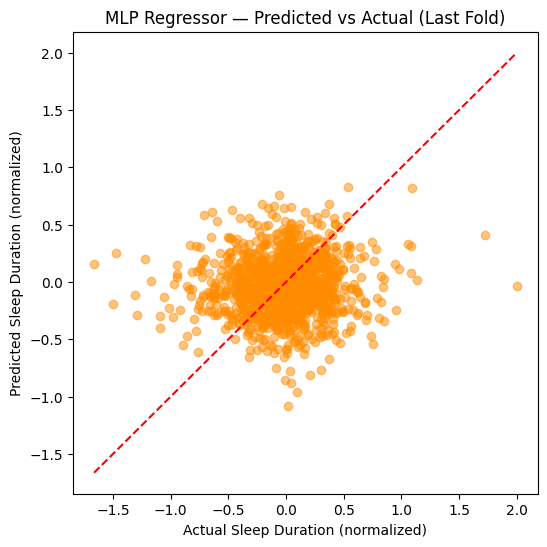

In [40]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(512, 256, 128),  # network ลึกขึ้นกว่าของเดิม
    activation='relu',
    solver='adam',
    learning_rate_init=0.0001,
    max_iter=10000,     # ให้เรียนรู้ได้นานขึ้น
    random_state=42
)

mlp_metrics = train_evaluate_model(mlp, X, y, model_name="MLP Regressor", n_splits=5, scale=True)

XGBoost input feature size: (6460, 63)
XGBoost — Fold 1 | MAE: 0.2446, RMSE: 0.3358, R²: 0.0238
XGBoost — Fold 2 | MAE: 0.2500, RMSE: 0.3438, R²: -0.0073
XGBoost — Fold 3 | MAE: 0.2414, RMSE: 0.3290, R²: 0.0324
XGBoost — Fold 4 | MAE: 0.2461, RMSE: 0.3346, R²: -0.0104
XGBoost — Fold 5 | MAE: 0.2499, RMSE: 0.3386, R²: 0.0114

XGBoost — Average across 5 folds:
MAE  : 0.2464
RMSE : 0.3364
R²   : 0.0100


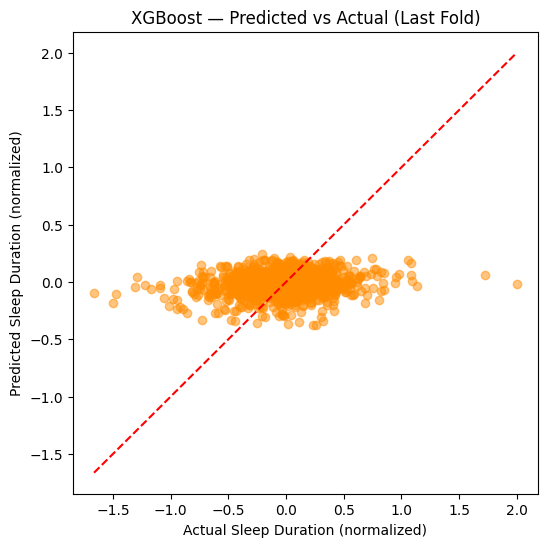

In [41]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=10,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.3,
    random_state=42,
    tree_method='hist'
)

xgb_metrics = train_evaluate_model(xgb_model, X, y, model_name="XGBoost", n_splits=5, scale=True)

Decision Tree input feature size: (6460, 63)
Decision Tree — Fold 1 | MAE: 0.2598, RMSE: 0.3616, R²: -0.1317
Decision Tree — Fold 2 | MAE: 0.2731, RMSE: 0.3728, R²: -0.1847
Decision Tree — Fold 3 | MAE: 0.2690, RMSE: 0.3716, R²: -0.2340
Decision Tree — Fold 4 | MAE: 0.2636, RMSE: 0.3665, R²: -0.2126
Decision Tree — Fold 5 | MAE: 0.2743, RMSE: 0.3740, R²: -0.2065

Decision Tree — Average across 5 folds:
MAE  : 0.2680
RMSE : 0.3693
R²   : -0.1939


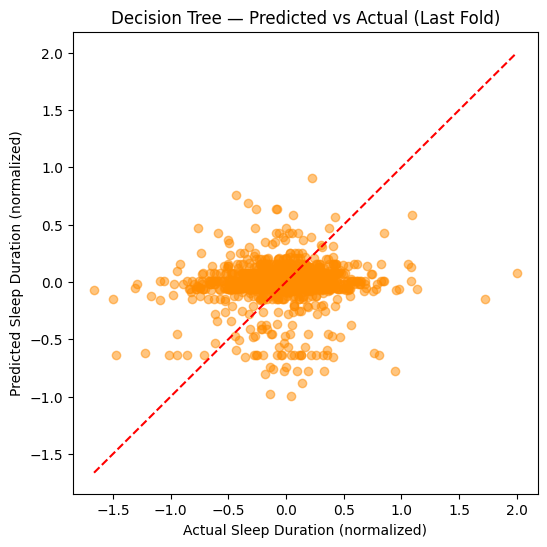

In [42]:
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor(
    max_depth=10,          # ควบคุมความลึกของต้นไม้ (ลึกเกิน = overfit)
    min_samples_split=5,   # จำนวน sample ขั้นต่ำก่อน split
    min_samples_leaf=3,    # จำนวน sample ขั้นต่ำใน leaf node
    random_state=42
)

tree_metrics = train_evaluate_model(tree_model, X, y, model_name="Decision Tree", n_splits=5, scale=True)

Linear Regression input feature size: (6460, 63)
Linear Regression — Fold 1 | MAE: 0.2423, RMSE: 0.3412, R²: -0.0079
Linear Regression — Fold 2 | MAE: 0.2497, RMSE: 0.3443, R²: -0.0103
Linear Regression — Fold 3 | MAE: 0.2443, RMSE: 0.3337, R²: 0.0049
Linear Regression — Fold 4 | MAE: 0.2416, RMSE: 0.3331, R²: -0.0016
Linear Regression — Fold 5 | MAE: 0.2460, RMSE: 0.3384, R²: 0.0128

Linear Regression — Average across 5 folds:
MAE  : 0.2448
RMSE : 0.3381
R²   : -0.0004


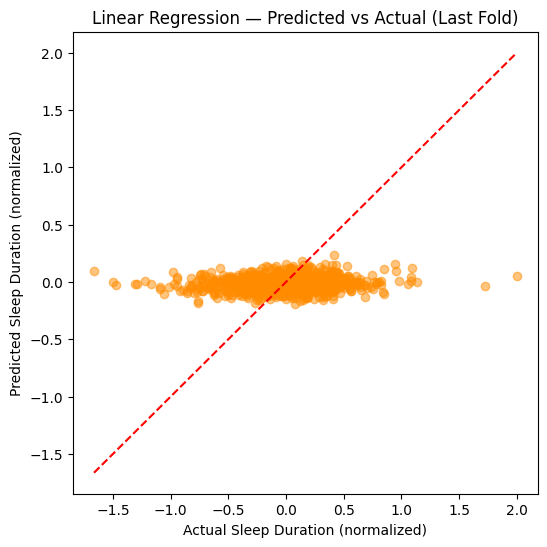

In [43]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_metrics = train_evaluate_model(
  lin_model, X, y, model_name="Linear Regression", n_splits=5, scale=True)

In [44]:
# SLOT 17: Compare All Models
results = pd.DataFrame({
    "Model": ["MLP Regressor", "XGBoost", "Decision Tree", "Linear Regression"],
    "MAE": [mlp_metrics[0], xgb_metrics[0], tree_metrics[0], lin_metrics[0]],
    "RMSE": [mlp_metrics[1], xgb_metrics[1], tree_metrics[1], lin_metrics[1]],
    "R²": [mlp_metrics[2], xgb_metrics[2], tree_metrics[2], lin_metrics[2]],
})

results = results.sort_values(by='R²', ascending=False)
print(results)


               Model       MAE      RMSE        R²
1            XGBoost  0.246390  0.336354  0.009995
3  Linear Regression  0.244782  0.338128 -0.000415
2      Decision Tree  0.267961  0.369306 -0.193888
0      MLP Regressor  0.309507  0.412726 -0.491424
